<a href="https://colab.research.google.com/github/colber94/CS230_FinalProject/blob/master/UNET_test_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/jakeret/unet.git
!pip install rasterio

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-4x_hn79e
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-4x_hn79e
  Created wheel for unet: filename=unet-0.0.post0.dev62+g46a9d34-py2.py3-none-any.whl size=25334 sha256=eaa4a641e12c034cfd3f7cee09214ee9bbf4f80c10332abe5a93808f194094a8
  Stored in directory: /tmp/pip-ephem-wheel-cache-w92omcm2/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [3]:
%load_ext tensorboard
import tensorflow as tf
import unet
from PIL import Image
import pandas as pd
import matplotlib.pyplot as pp
import seaborn as sns
from glob import glob
from google.colab import files
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Preprocessing Original Files

In [10]:
# Loading and preprocessing data

# Preprocessing paramters
IMSIZE    = 2048  # images will be IMSIZE x IMSIZE.... KEEPS CRASHING 
N_CLASSES = 4    # 2, 4, or 10

# Loading satellite images into an array
sat_files = np.sort(glob("/content/drive/My Drive/cs230/sen2_composite/*.tif")) 
sat_imgs = [Image.open(s) for s in sat_files]

#Loading nclasses version of lte mask images into an array


lte_files = np.sort(glob("/content/drive/My Drive/cs230/lte/cat{}*.tif".format(N_CLASSES)))
lte_imgs = [Image.open(l) for l in lte_files]

# Resizing and scaling images
X = np.asarray([np.asarray(img.resize((IMSIZE, IMSIZE), Image.ANTIALIAS))/255. for img in sat_imgs])
Y = np.asarray([np.asarray(img.resize((IMSIZE, IMSIZE), Image.ANTIALIAS)) for img in lte_imgs])

Y_onehot = [tf.one_hot(y, N_CLASSES) for y in Y]

4
8
12
16
20
24
28
32


# New Section

In [0]:
# Takes in an image and returns a list of size x size images from that original one
def image_crop(input, size):
    image = Image.open(input)
    imgwidth, imgheight = im.size
    rows = np.int(imgheight/size)
    cols = np.int(imgwidth/size)
    output_images = []
    for i in range(rows):
        for j in range(cols):
            new_area= (j*size, i*size, (j+1)*size, (i+1)*size)
            new_image = image.crop(new_area)
            output.append(new_image)
    return output_images
     

In [15]:
# Loading and preprocessing data

# Preprocessing paramters
RESIZE = 2048     # Takes in original at 5049 and splits into smaller images with this size
IMSIZE = 512  # images will be IMSIZE x IMSIZE after downsampling
N_CLASSES = 4    # 2, 4, or 10




# Loading satellite images into an array and split into smaller photos
sat_files = np.sort(glob("/content/drive/My Drive/cs230/sen2_composite/*.tif"))
sat_imgs = []
for s in sat_files[:8]:
    sat_imgs.extend(crop(s,RESIZE))
    print(len(sat_imgs))  

# Loading 4GLTE photos in and splitting into smaller photos 
lte_files = np.sort(glob("/content/drive/My Drive/cs230/lte/cat{}*.tif".format(N_CLASSES)))
lte_imgs = []
for l in lte_files[:8]:
    lte_imgs.extend(crop(l,RESIZE))
    print(len(lte_imgs))  



# Resizing and scaling images
X = np.asarray([np.asarray(img.resize((IMSIZE, IMSIZE), Image.ANTIALIAS))/255. for img in sat_imgs])
Y = np.asarray([np.asarray(img.resize((IMSIZE, IMSIZE), Image.ANTIALIAS)) for img in lte_imgs])

Y_onehot = [tf.one_hot(y, N_CLASSES) for y in Y]

4
8
12
16
20
24
28
32
4
8
12
16
20
24
28
32


32


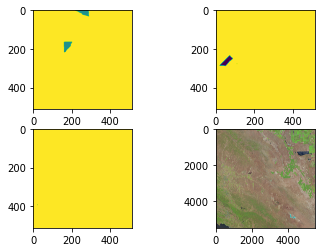

In [31]:
print(len(X))
for i in range(4):
  pp.subplot(2,2,i+1)
  pp.imshow(Y[i])
pp.imshow(Image.open(sat_files[0]))

# Model Training

In [27]:
%tensorboard --logdir /content/unet/

<IPython.core.display.Javascript object>

In [28]:
# Setting up the datasets for tf
N_TRAIN      = int(len(X)*.9)
print(N_TRAIN)
CLASS_WEIGHTS = [5,5,5,1] # See https://github.com/keras-team/keras/issues/3653

assert(len(CLASS_WEIGHTS) == N_CLASSES) # don't forget to set weights for all the classes

Y_onehot_weighted = [y*np.asarray(CLASS_WEIGHTS) for y in Y_onehot] 

sat_lte_dataset = tf.data.Dataset.from_tensor_slices((X, Y_onehot_weighted))
train_set = sat_lte_dataset.take(N_TRAIN)
test_set = sat_lte_dataset.skip(N_TRAIN)

28


In [0]:
# Model hyperparameters
LEARNING_RATE = 0.0001
LAYER_DEPTH   = 5
ROOT_FILTERS  = 64
DROPOUT       = 0.0

# Building the model
unet_model = unet.build_model(IMSIZE, IMSIZE,
                          channels = 3,
                          num_classes = N_CLASSES,
                          layer_depth = LAYER_DEPTH,
                          filters_root= ROOT_FILTERS,
                          dropout_rate = DROPOUT,
                          padding = "same"
                          )

unet.finalize_model(unet_model,
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                    learning_rate=LEARNING_RATE
                    ) 

trainer = unet.Trainer(checkpoint_callback=False)

In [30]:
# Dataset parameters 
EPOCHS        = 500
BATCH_SIZE    = 1 # because little GPU RAM on colab... 
                  # can increase sometimes

trainer.fit(unet_model,
            train_set,
            test_set,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE)  

Epoch 1/500
28/28 [==============================] - 16s 586ms/step - loss: 3.1247 - categorical_crossentropy: 3.1282 - categorical_accuracy: 0.4501 - mean_iou: 0.1492 - dice_coefficient: 0.3242 - auc: 0.6520 - val_loss: 3.2087 - val_categorical_crossentropy: 3.2073 - val_categorical_accuracy: 0.6701 - val_mean_iou: 0.1770 - val_dice_coefficient: 0.3398 - val_auc: 0.7773 - learning_rate: 1.0000e-04
Epoch 2/500
28/28 [==============================] - 15s 544ms/step - loss: 3.1233 - categorical_crossentropy: 3.1242 - categorical_accuracy: 0.6864 - mean_iou: 0.1500 - dice_coefficient: 0.3276 - auc: 0.7488 - val_loss: 3.2072 - val_categorical_crossentropy: 3.2035 - val_categorical_accuracy: 0.6713 - val_mean_iou: 0.1777 - val_dice_coefficient: 0.3423 - val_auc: 0.7731 - learning_rate: 1.0000e-04
Epoch 3/500
28/28 [==============================] - 15s 550ms/step - loss: 3.1206 - categorical_crossentropy: 3.1231 - categorical_accuracy: 0.6867 - mean_iou: 0.1518 - dice_coefficient: 0.3359 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


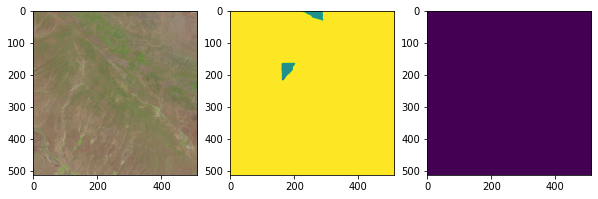

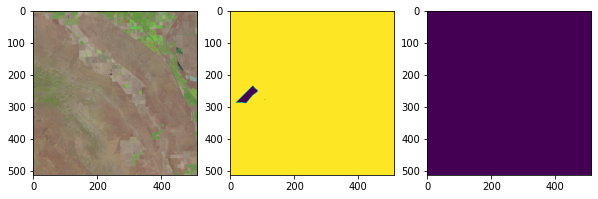

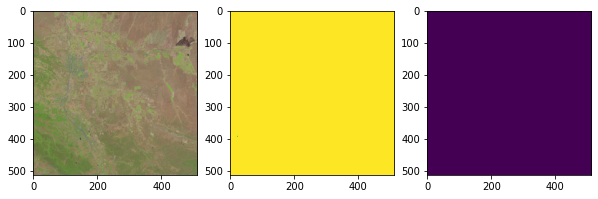

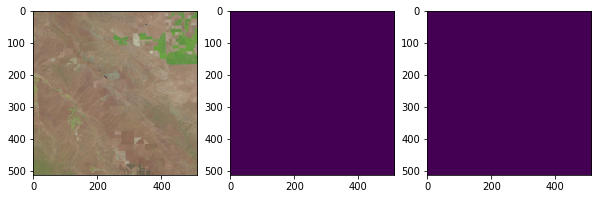

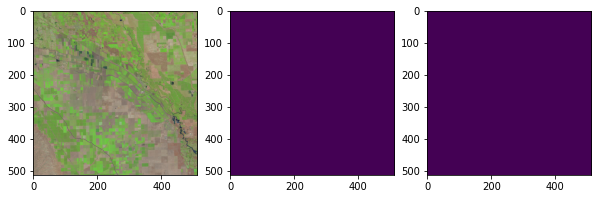

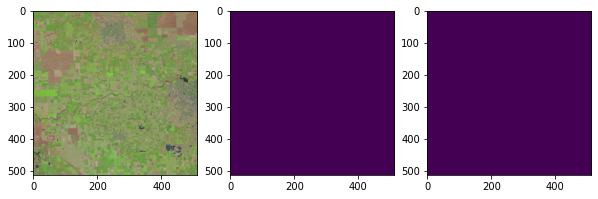

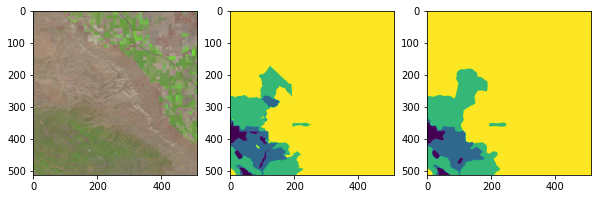

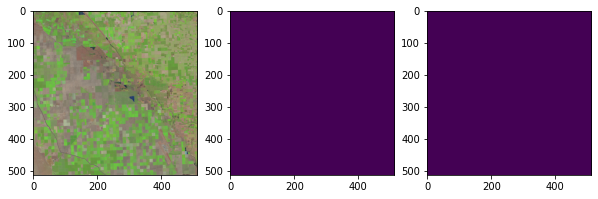

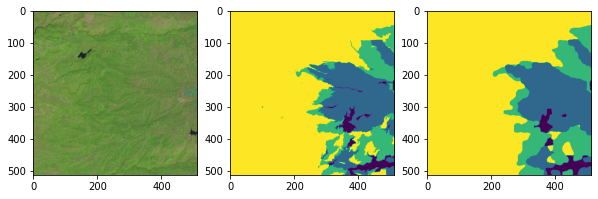

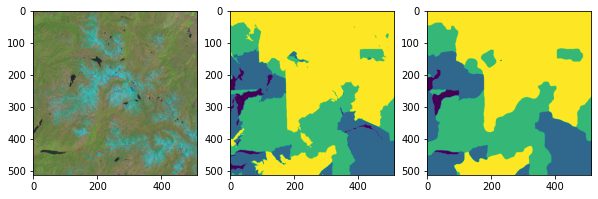

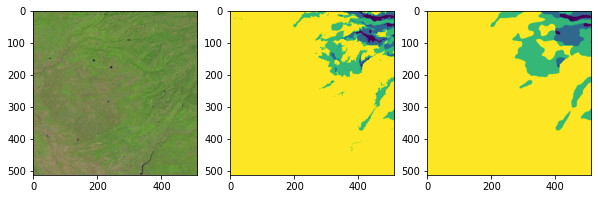

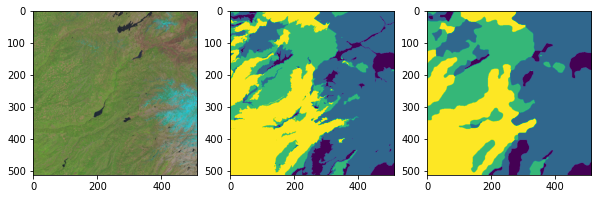

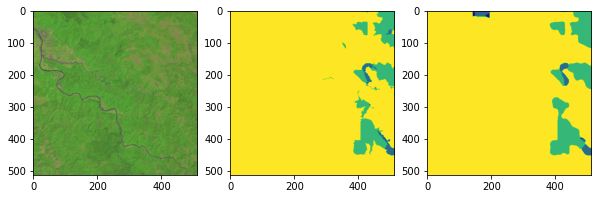

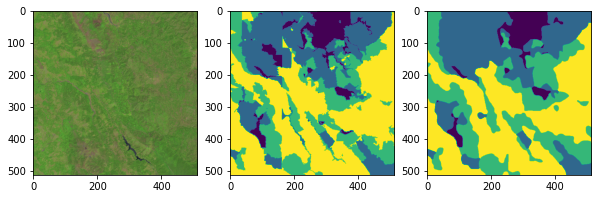

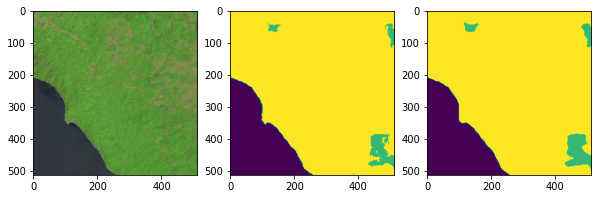

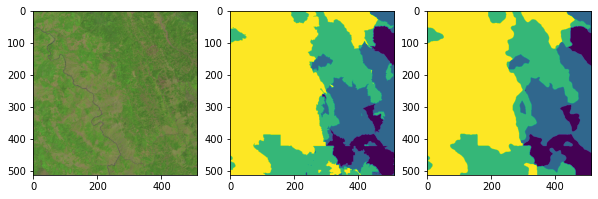

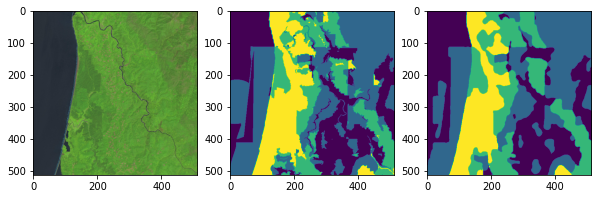

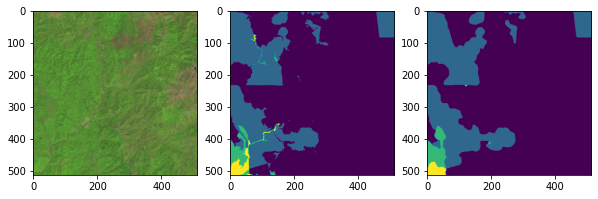

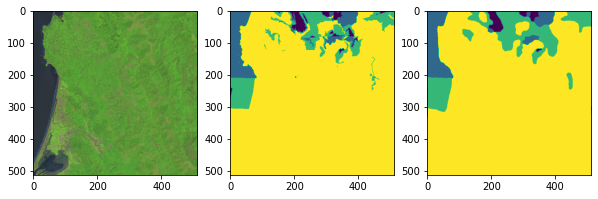

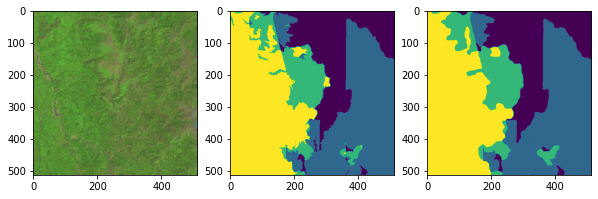

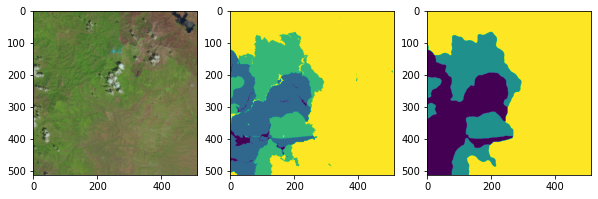

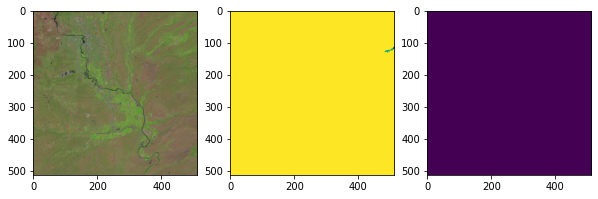

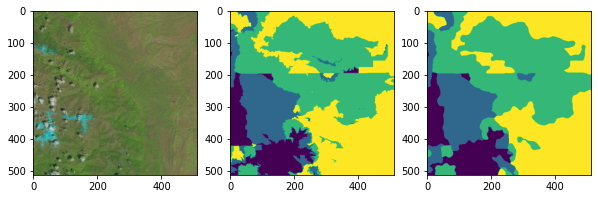

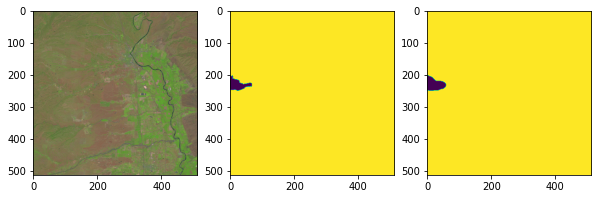

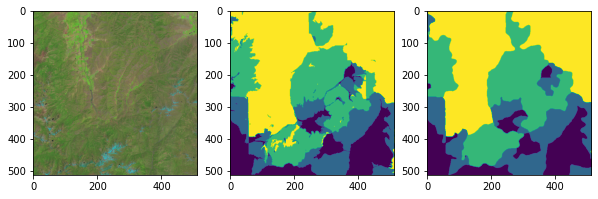

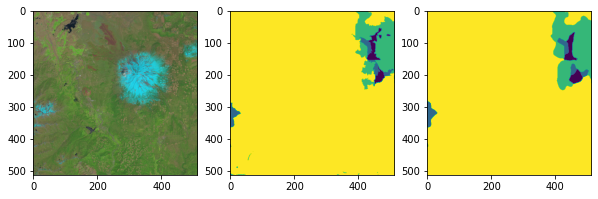

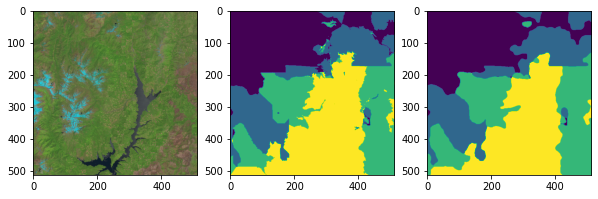

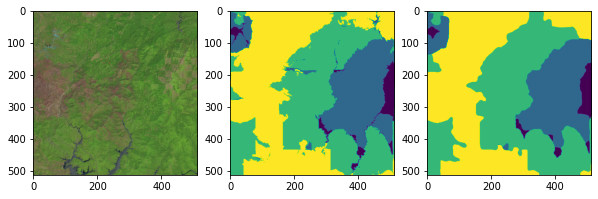

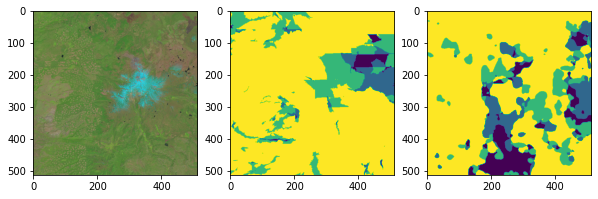

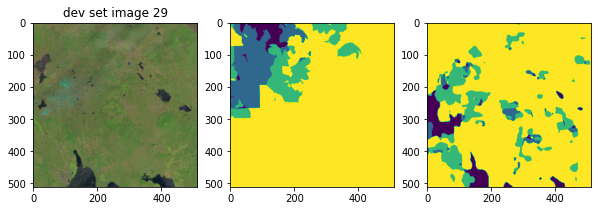

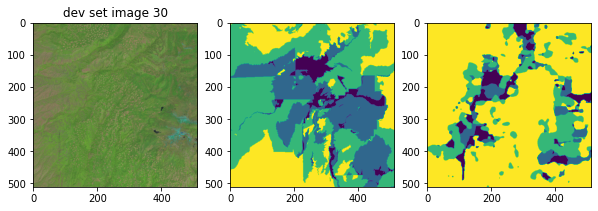

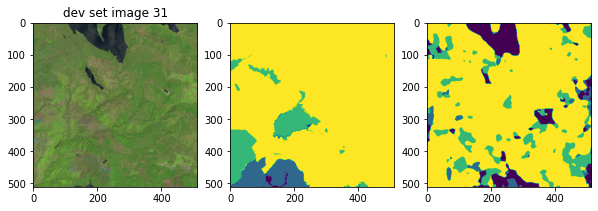

In [32]:
for i in range(len(X)):
  pp.figure(figsize=(10,10))
  pp.subplot(133)
  pp.imshow(unet_model.predict(np.expand_dims(X[i],0))[0].argmax(-1))

  pp.subplot(132)
  pp.imshow(Y[i])

  pp.subplot(131)
  pp.imshow(X[i])
  if i > N_TRAIN:
    pp.title("dev set image {}".format(i))